Here's some guide for this assessment:

1. Obtain the dataset file from the assessment instruction.
2. The dataset file is split into image and label folder. You need to find a way to read all the images and labels as numpy array.
3. The most straight forward way to read an image is to use OpenCV (cv2.imread())
4. Resize your image and label into width and height of (128,128)
5. For the label, it is in the form of binary mask image (black and white image), you need to find a way to read the mask image, then process the value of the pixels so that they become class label ([0,255] --> [0,1])
6. You can perform train test split on the numpy arrays for the images and labels using scikit learn.
7. You can convert the numpy array into tensorflow tensors using this method: tf.data.Dataset.from_tensor_slices()
8. You can combine the images and labels together to form a single dataset using this method: tf.data.Dataset.zip(), do this for both train and test data.
9. Perform the same dataset preparation step as the demo.
10. Construct a UNet, then train this model so that it reaches at least 80% accuracy for both train and test.
11. Deploy the model and make prediction

(Hint: You can refer to the image segmentation tutorial from tensorflow)

In [1]:
#1. Import packages
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob, os
import keras
import mlflow
import datetime

# Variable declaration for filepath, images and mask
filepath = r"datasets/data-science-bowl-2018-2/train/"
images = []
masks = []

In [2]:
#Use os.listdir() method to list down all the image file, then use a for loop to read the images.

# for filepath in os.listdir(filepath):
#     #function you will use here:
#     os.path.join()
#     cv2.imread()
#     cv2.cvtColor()
#     cv2.resize()

#Use this for loop, do the same thing for the label. But I suggest you read the label as a grayscale image.


#2. Load images
image_path = os.path.join(filepath,'inputs')
for img in os.listdir(image_path):
    #Get the full path of the image file
    full_path = os.path.join(image_path,img)
    #Read the image file based on the full path
    img_np = cv2.imread(full_path)
    #Convert the image from bgr to rgb
    img_np = cv2.cvtColor(img_np,cv2.COLOR_BGR2RGB)
    #Resize the image into 128x128
    img_np = cv2.resize(img_np,(128,128))
    #Place the image into the empty list
    images.append(img_np)

#3. Load masks
mask_path = os.path.join(filepath,'masks')
for mask in os.listdir(mask_path):
    #Get the full path of the mask file
    full_path = os.path.join(mask_path,mask)
    #Read the mask file as a grayscale image
    mask_np = cv2.imread(full_path,cv2.IMREAD_GRAYSCALE)
    #Resize the image into 128x128
    mask_np = cv2.resize(mask_np,(128,128))
    #Place the mask into the empty list
    masks.append(mask_np)

In [3]:
#4. Convert the list of np array into a full np array
images_np = np.array(images)
masks_np = np.array(masks)

In [4]:
#5. Data preprocessing
#5.1. Expand the mask dimension to include the channel axis
masks_np_exp = np.expand_dims(masks_np,axis=-1)
#5.2. Convert the mask value into just 0 and 1
converted_masks_np = np.round(masks_np_exp/255)
#5.3. Normalize the images pixel value
normalized_images_np = images_np/255.0

In [5]:
#6. Perform train test split
from sklearn.model_selection import train_test_split
SEED = 12345
X_train,X_test,y_train,y_test = train_test_split(normalized_images_np,converted_masks_np,shuffle=True,random_state=SEED)

In [6]:
#7. Convert the numpy array into tensorflow tensors
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)

In [7]:
#8. Combine features and labels together to form a zip dataset
train = tf.data.Dataset.zip((X_train_tensor,y_train_tensor))
test = tf.data.Dataset.zip((X_test_tensor,y_test_tensor))

In [8]:
"""
Continue the rest of your assessment here.
"""

'\nContinue the rest of your assessment here.\n'

In [9]:
# 9. Build a custom U-Net model 
def build_custom_unet(output_channels):
    """
    Build a U-Net model for semantic segmentation (multiple output classes).
    :param output_channels: Number of output channels (e.g., number of semantic classes).
    :return: A U-Net model.
    """
    # Transfer Learning for Downsampling Path
    # Use MobileNetV2 as the base feature extractor (pre-trained on ImageNet).
    base_model = keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
    base_model.trainable = False  # Freeze the pre-trained model to retain pre-learned features.

    # Specify layers from MobileNetV2 to be used for skip connections.
    layer_names = [
        'block_1_expand_relu',   # 64x64 resolution feature map
        'block_3_expand_relu',   # 32x32 resolution feature map
        'block_6_expand_relu',   # 16x16 resolution feature map
        'block_13_expand_relu',  # 8x8 resolution feature map
        'block_16_project',      # 4x4 bottleneck feature map
    ]

    # Extract outputs of these specific layers from MobileNetV2.
    downsample_layers = [base_model.get_layer(name).output for name in layer_names]

    # Define a downsampling model that outputs features at each specified layer.
    down_stack = keras.Model(inputs=base_model.input, outputs=downsample_layers)

    # Custom Upsampling Path
    def upsample(filters, size):
        """
        Create an upsampling block with Conv2DTranspose, BatchNormalization, and ReLU activation.
        :param filters: Number of filters in the Conv2DTranspose layer.
        :param size: Kernel size for the Conv2DTranspose layer.
        :return: A sequential model representing the upsampling block.
        """
        return keras.Sequential([
            keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same'),
            # Learnable upsampling with specified stride (doubles the spatial resolution).
            keras.layers.BatchNormalization(), # Normalize activations for stable learning.
            keras.layers.ReLU() # Non-linear activation.
        ])

    # Define the upsampling path with progressively fewer filters as resolution increases.
    up_stack = [
        upsample(512, 3),  # 4x4 -> 8x8
        upsample(256, 3),  # 8x8 -> 16x16
        upsample(128, 3),  # 16x16 -> 32x32
        upsample(64, 3),   # 32x32 -> 64x64
    ]

    # Define the Model
    inputs = keras.layers.Input(shape=[128, 128, 3]) # Input layer for 128x128 RGB images.
    skips = down_stack(inputs) # Generate feature maps from downsampling path.
    x = skips[-1]  # Start with the bottleneck feature map (4x4 resolution).

    # Reverse the skip connections to match the order of upsampling.
    skips = reversed(skips[:-1])

    # Perform upsampling and merge with corresponding skip connections.
    for up, skip in zip(up_stack, skips):
        x = up(x) # Upsample current feature map.
        x = keras.layers.Concatenate()([x, skip]) # Combine upsampled and skip features.

    # Output layer
    outputs = keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, padding='same', activation='softmax')(x)
    # Final layer upsamples to the original resolution (128x128) and predicts class probabilities.

    # Assemble the entire U-Net model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


# Build the U-Net model
OUTPUT_CLASSES = 2  # Example: 3 classes for semantic segmentation
model = build_custom_unet(OUTPUT_CLASSES)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 64, 64,   │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8, 8, 512) │  1,477,120 │ functional[0][4]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 16, 16,    │  2,508,032 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    516,736 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64,    │    156,992 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 128,  │      2,882 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 2)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,503,746 (24.81 MB)

 Trainable params: 4,659,842 (17.78 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

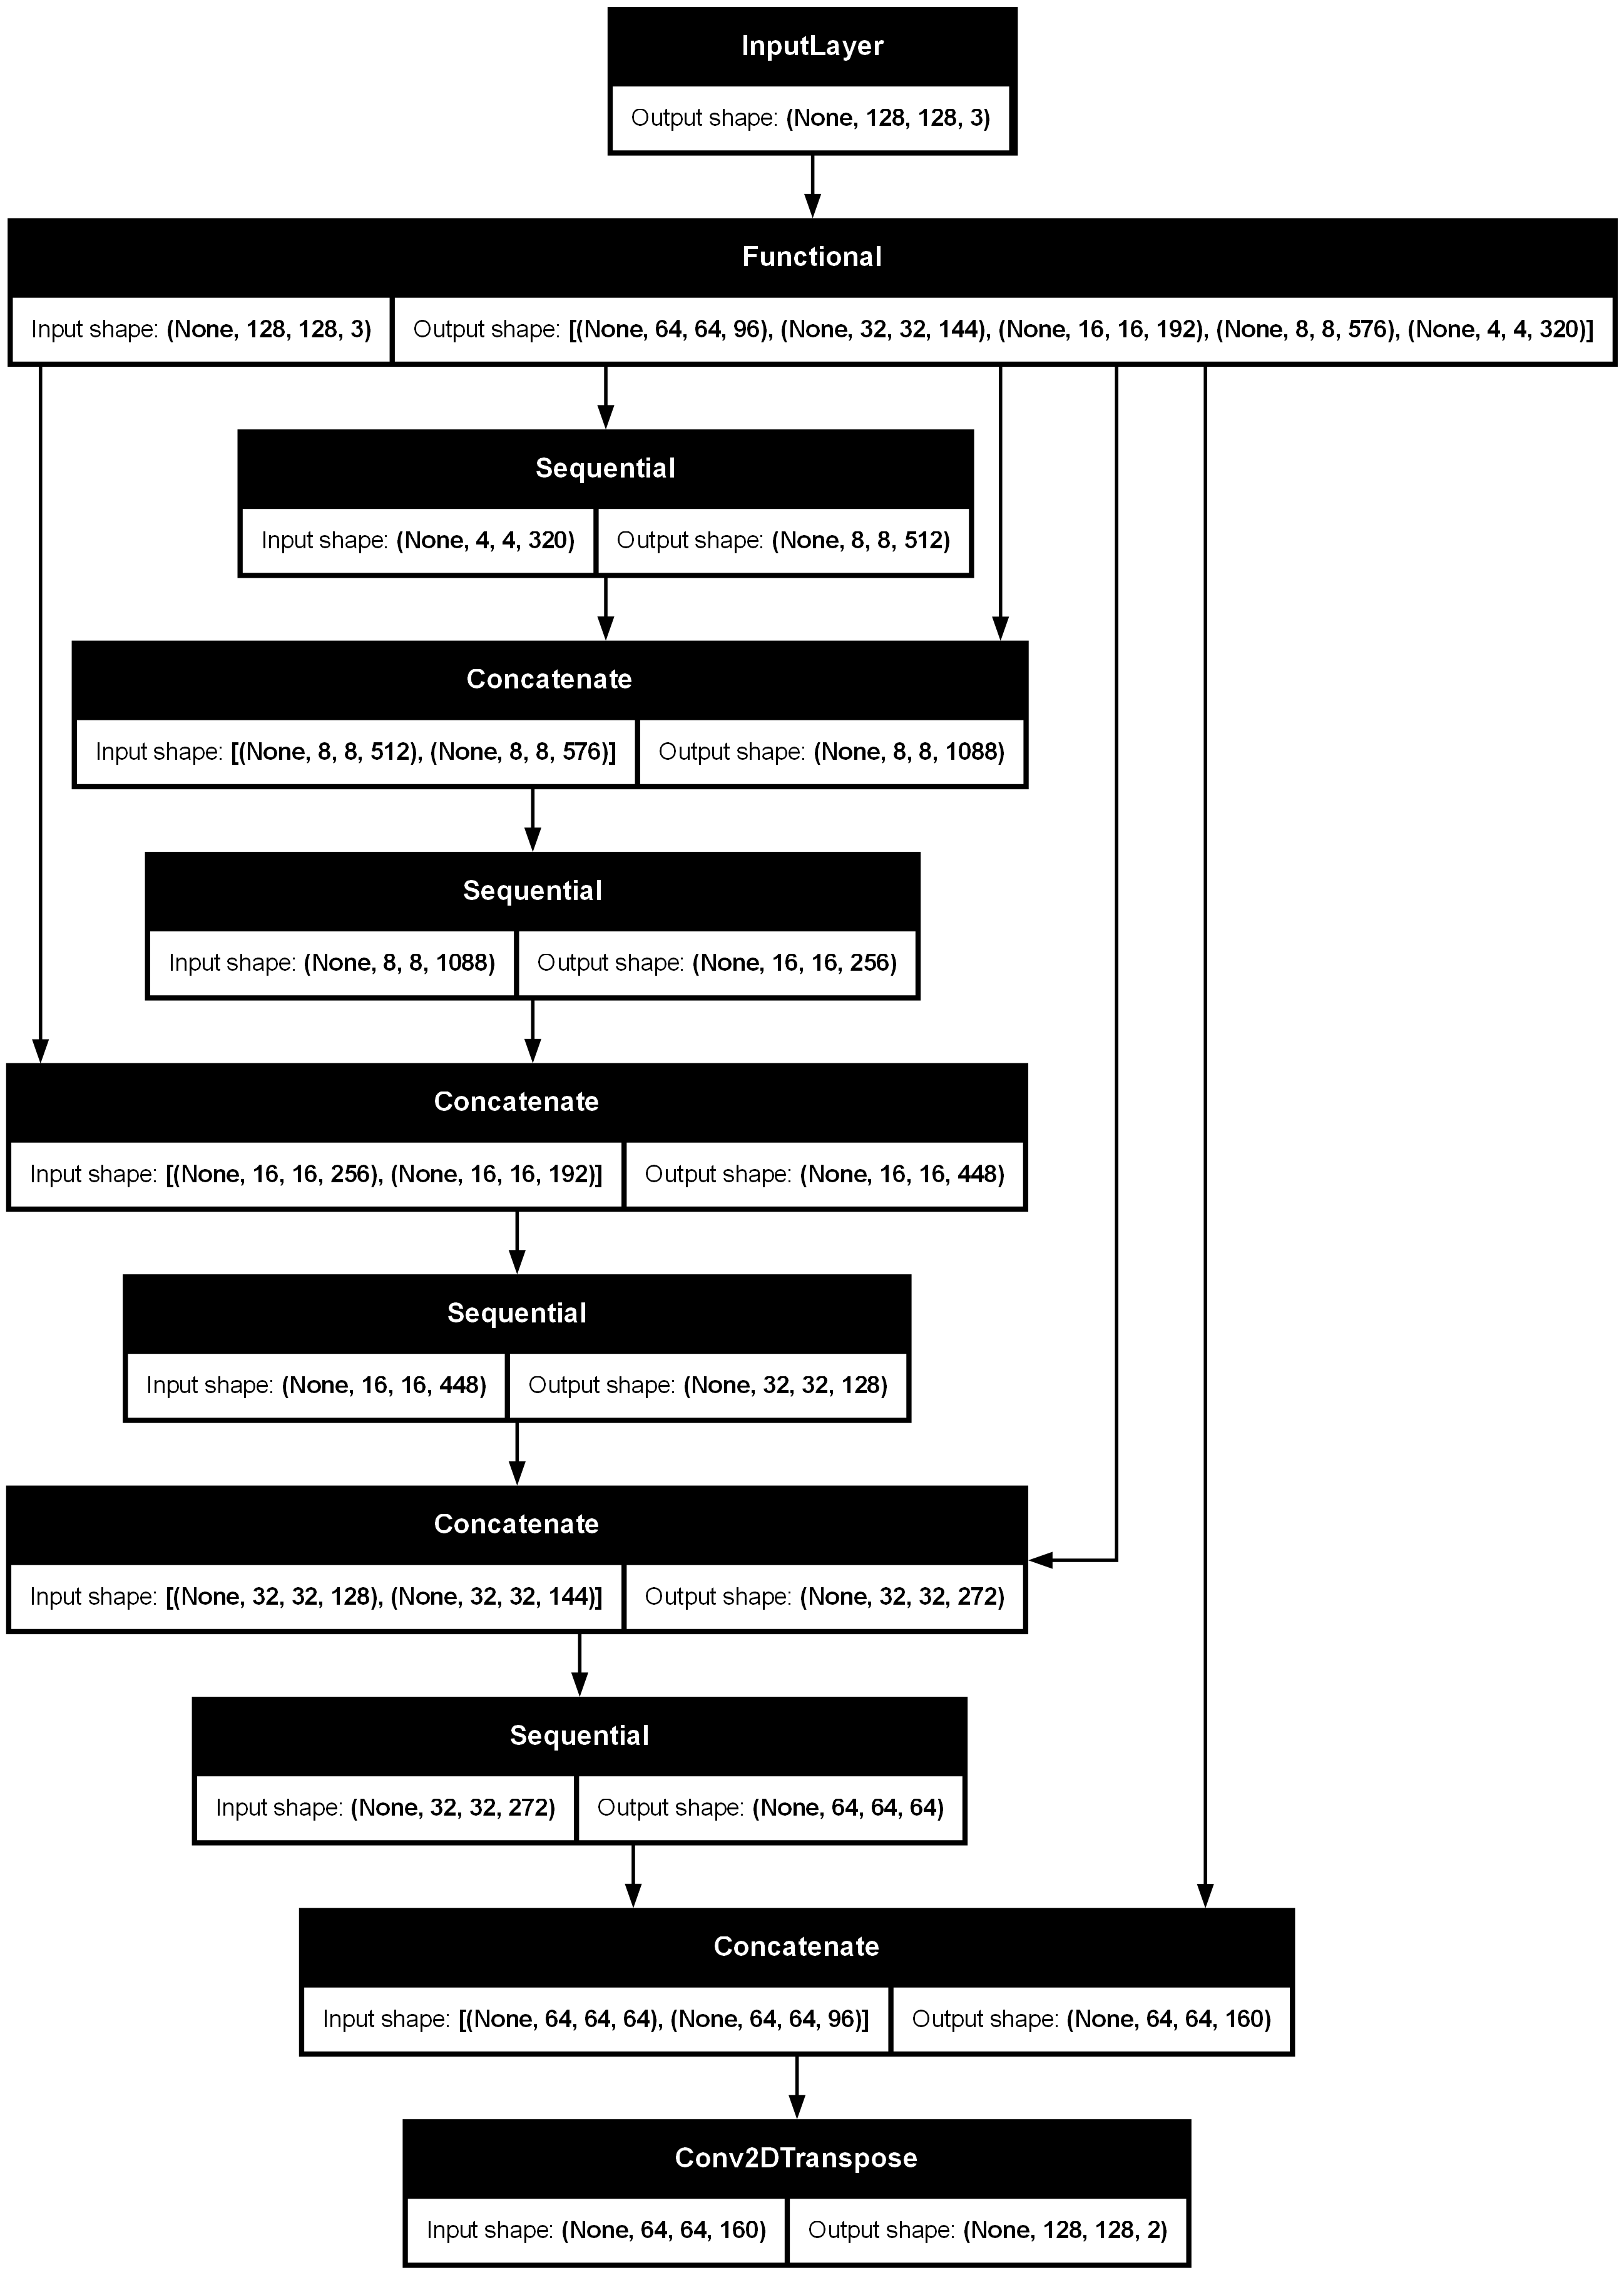

In [10]:
keras.utils.plot_model(
    model,                     # The Keras model instance to visualize
    to_file="Custom_U-Net_Model.png",  # File path to save the diagram
    show_shapes=True           # Include the input/output shape of each layer
)

In [11]:
# Compile the model
model.compile(optimizer='adam', # The Adam optimizer is used for training. It adjusts learning rates adaptively for better convergence.
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # multi-class classification where the target labels are integers (not one-hot encoded).
              metrics=['accuracy']) # Tracks accuracy as a performance metric during training and evaluation.

# Set the batch size for training and testing
BATCH_SIZE = 32  # Defines the number of samples per batch during training.

# Use TensorFlow's data optimization feature
AUTOTUNE = tf.data.AUTOTUNE  # Automatically optimizes data loading and preprocessing based on available resources.

train_batches = train.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE) # Caches the dataset in memory after the first epoch to avoid reloading and recomputation, speeding up training.
test_batches = test.batch(BATCH_SIZE) # Only batches the test dataset (no shuffle or caching). 

In [13]:
# Log the training into the Tensorboard
log_dir = "logs/custom_unet-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Monitors the validation loss during training.
    patience=10,                  # Stops training if 'val_loss' doesn't improve for 10 consecutive epochs.
    restore_best_weights=True,    # Restores the model weights from the epoch where 'val_loss' was the lowest.
    mode='min',                   # Indicates that the monitored metric ('val_loss') should be minimized.
    verbose=1                     # Prints messages when training stops due to early stopping.
)

In [15]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',      # Monitors the validation loss during training.
    factor=0.5,              # Reduces the learning rate by a factor of 0.5 when triggered.
    patience=5,              # Waits for 5 epochs without improvement before reducing the learning rate.
    min_lr=1e-6,             # Specifies the minimum learning rate to prevent it from becoming too small.
    verbose=1                # Prints messages when the learning rate is reduced.
)

In [16]:
# Train the model
EPOCHS = 100
model.fit(
    train.batch(32),              # Feeds the training data to the model in batches of size 32.
    validation_data=test.batch(32),  # Feeds the validation data in batches of size 32 to evaluate model performance.
    epochs=EPOCHS,                   # Specifies the maximum number of training epochs (100 in this case).
    callbacks=[tensorboard_callback,early_stopping,lr_scheduler],     # # Adds callbacks to monitor and optimize the training process
    verbose=1                     # Prints detailed logs of training progress
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6396 - loss: 0.7503 - val_accuracy: 0.8603 - val_loss: 0.3622 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8773 - loss: 0.2895 - val_accuracy: 0.8889 - val_loss: 0.2264 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9200 - loss: 0.1889 - val_accuracy: 0.9046 - val_loss: 0.1917 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9373 - loss: 0.1523 - val_accuracy: 0.9102 - val_loss: 0.1767 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9448 - loss: 0.1342 - val_accuracy: 0.9138 - val_loss: 0.1697 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9487 - loss: 0.1242 - val_accuracy: 0.9173 - val_loss: 0.1650 - learning_rate: 0.0010
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9516 - loss: 0.1175 - val_acc

In [19]:
# Show the command to run Tensorboard log based on the trained model
print(f"Run `tensorboard --logdir={log_dir}` to view logs in TensorBoard.")

Run `tensorboard --logdir=logs/custom_unet-20250114-122623` to view logs in TensorBoard.


In [22]:
os.makedirs("models", exist_ok=True)
model.save("models/custom-unet.h5")

In [24]:
from tensorflow.keras.models import load_model
loaded_model = load_model('models/custom-unet.h5')

# Check the model summary to verify it loaded correctly
loaded_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 64, 64,   │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8, 8, 512) │  1,477,120 │ functional[0][4]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 16, 16,    │  2,508,032 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    516,736 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64,    │    156,992 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 128,  │      2,882 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 2)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,503,748 (24.81 MB)

 Trainable params: 4,659,842 (17.78 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

 Optimizer params: 2 (12.00 B)

In [30]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = loaded_model.evaluate(test_batches)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.9658 - loss: 0.0837
Test Loss: 0.0842973068356514
Test Accuracy: 0.9654250144958496


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


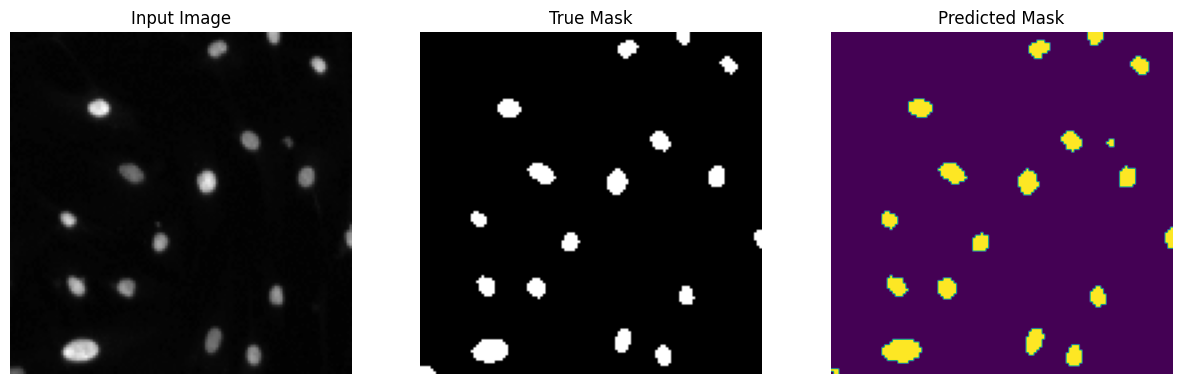

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


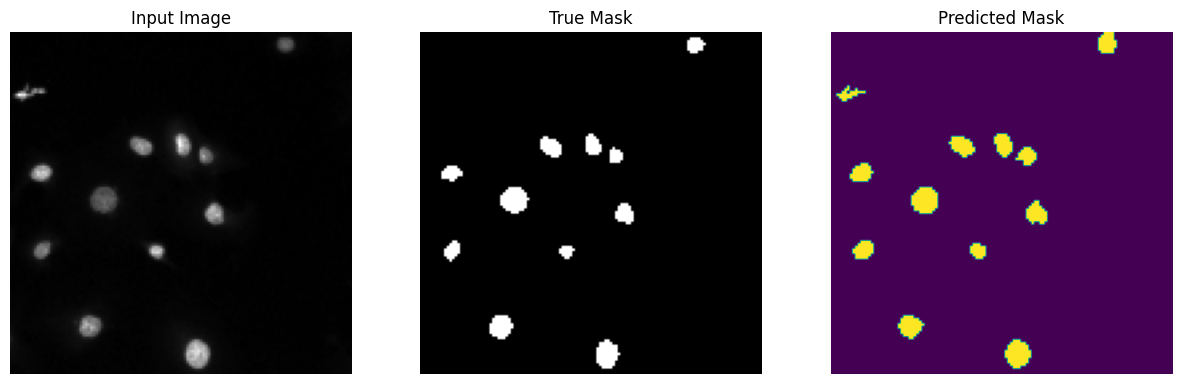

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


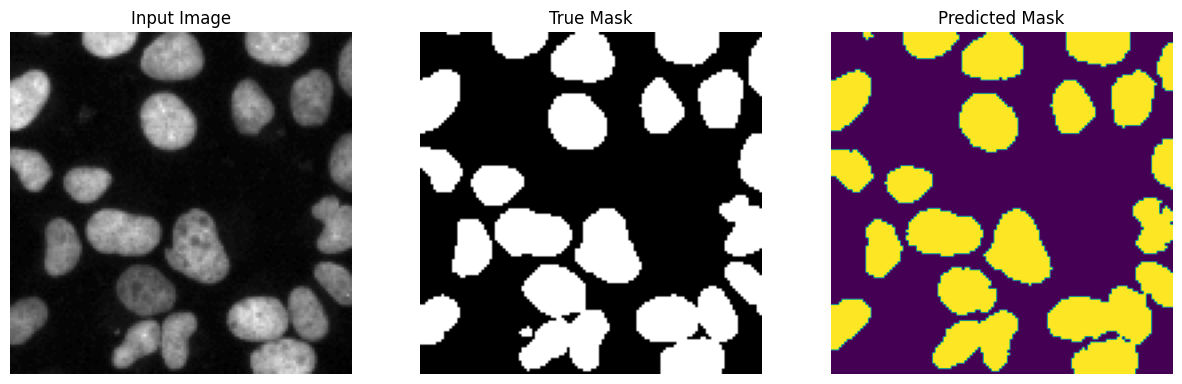

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


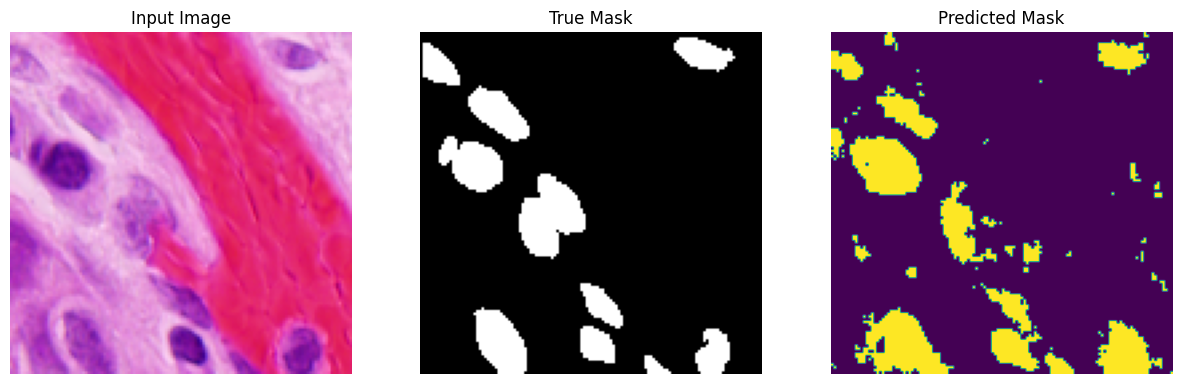

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


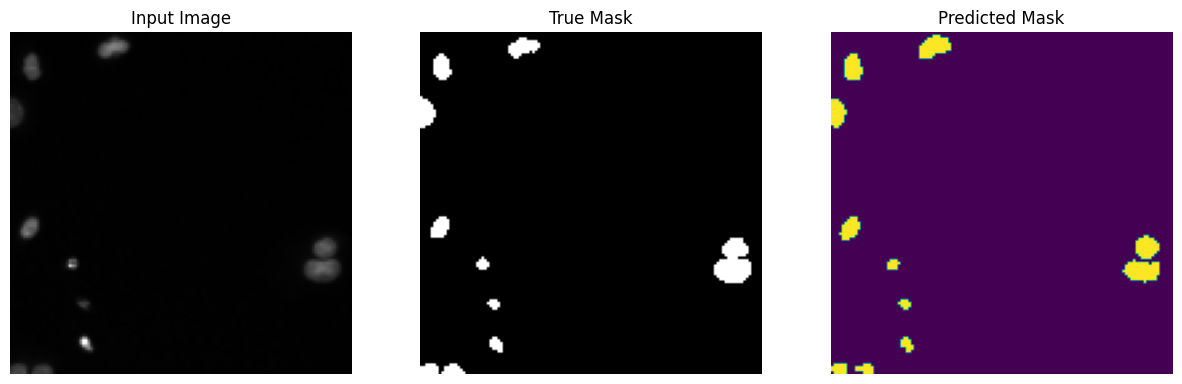

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


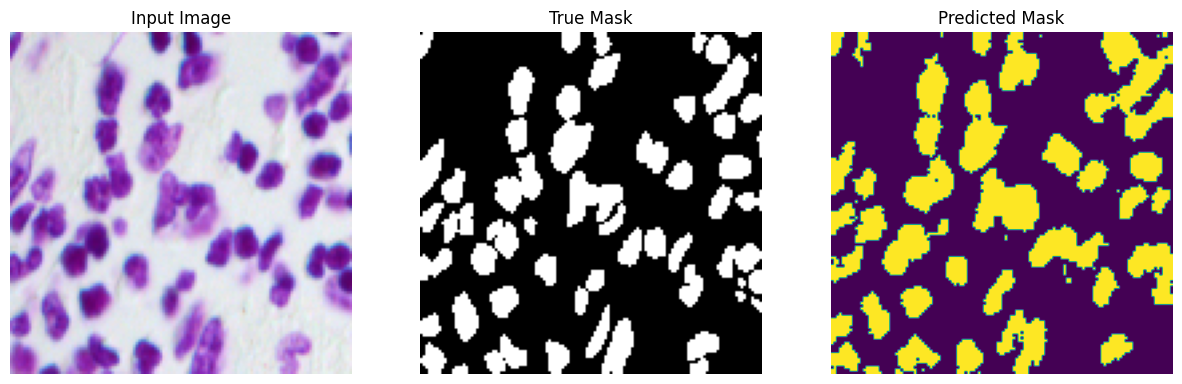

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


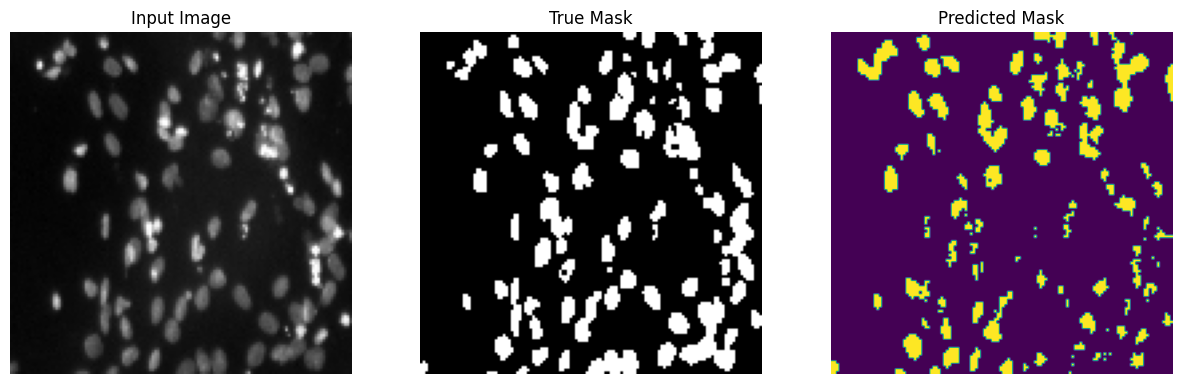

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


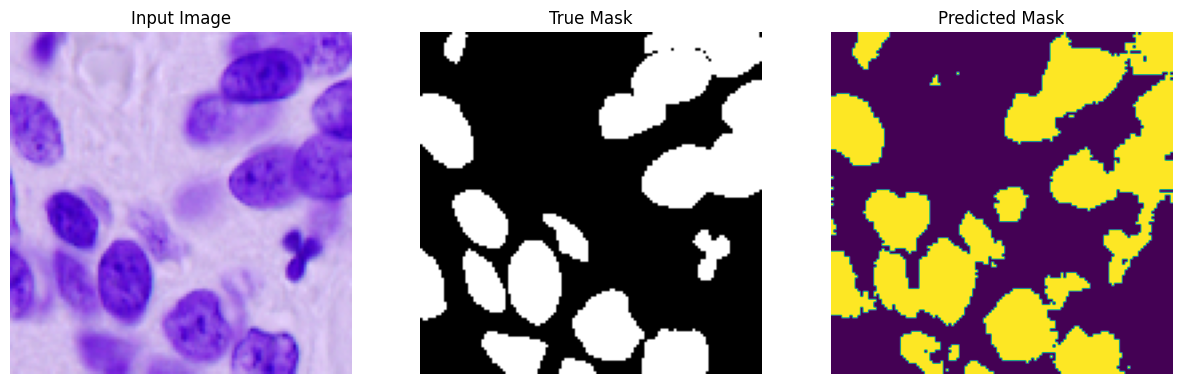

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


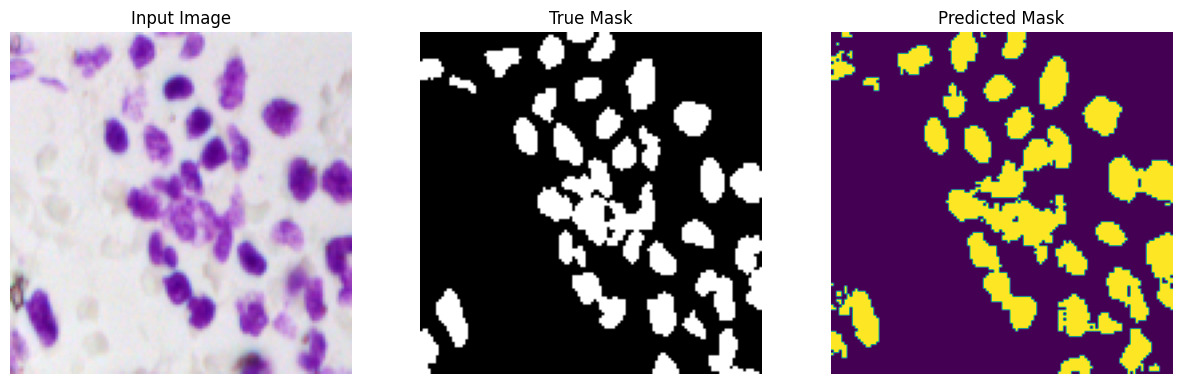

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


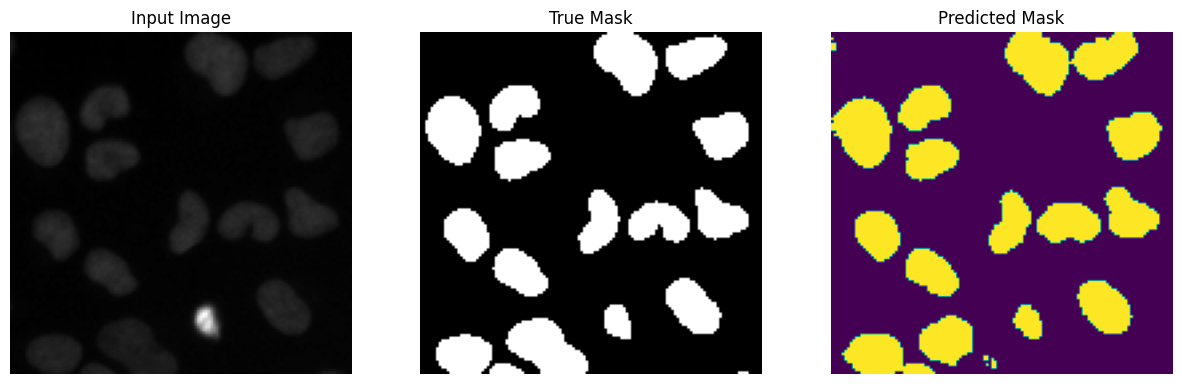

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


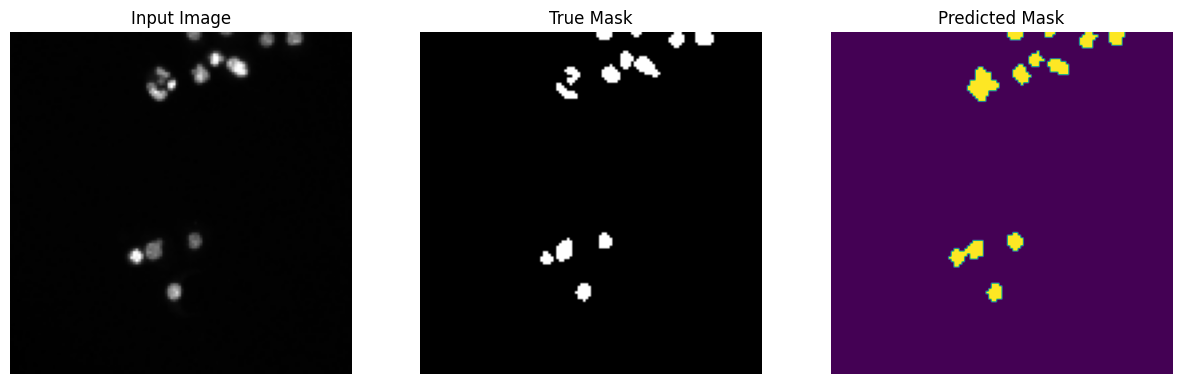

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


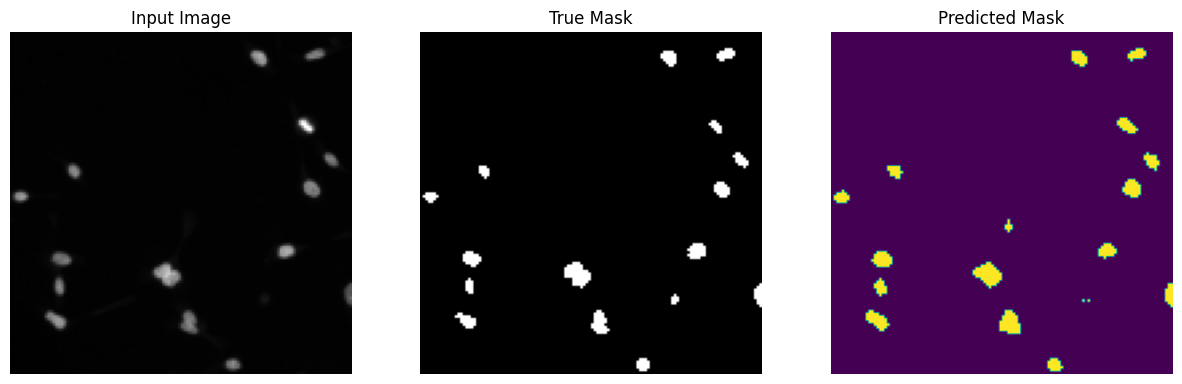

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


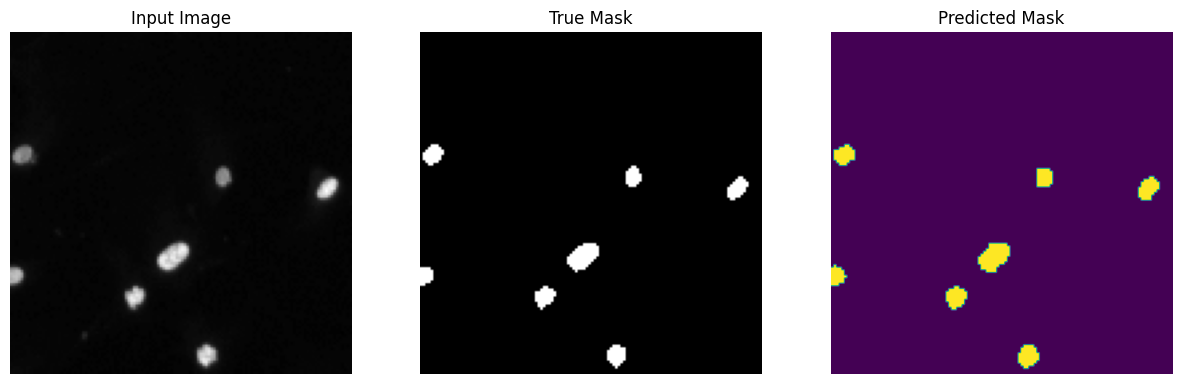

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


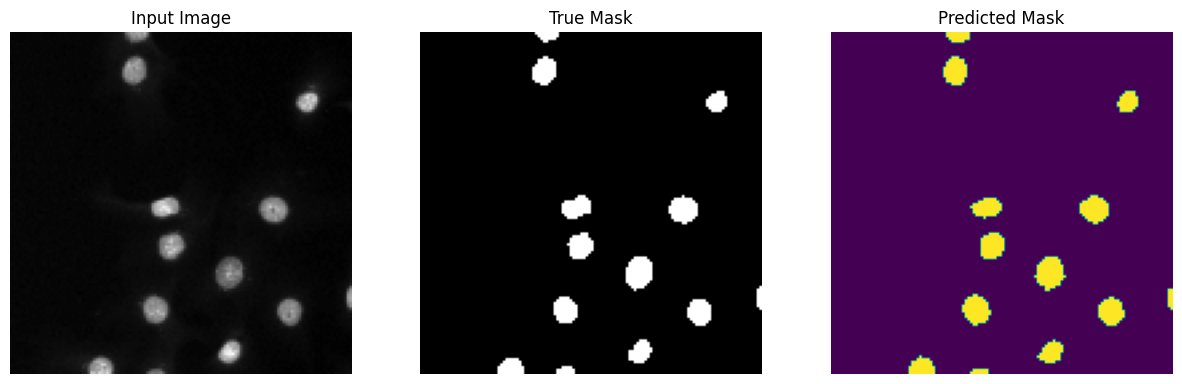

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


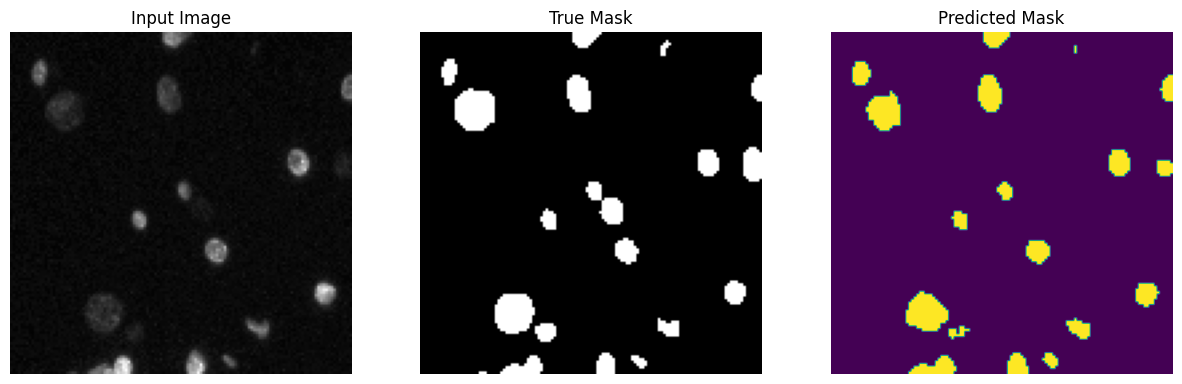

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


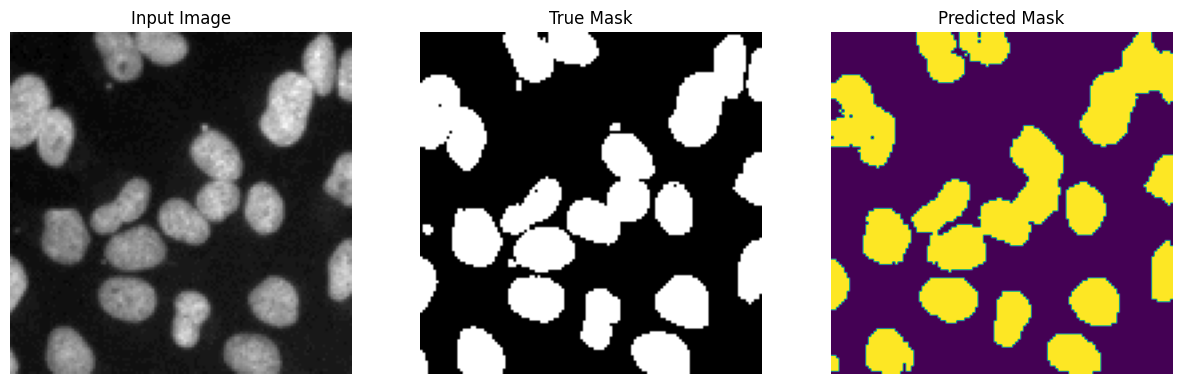

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


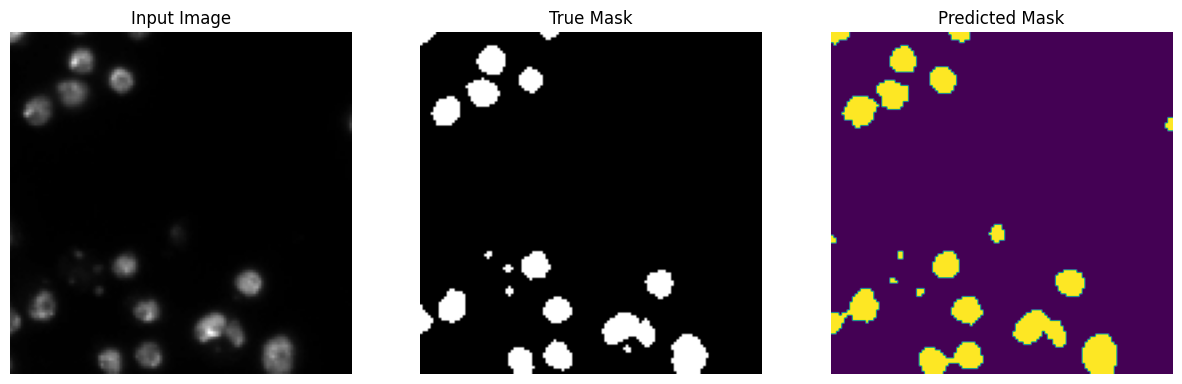

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


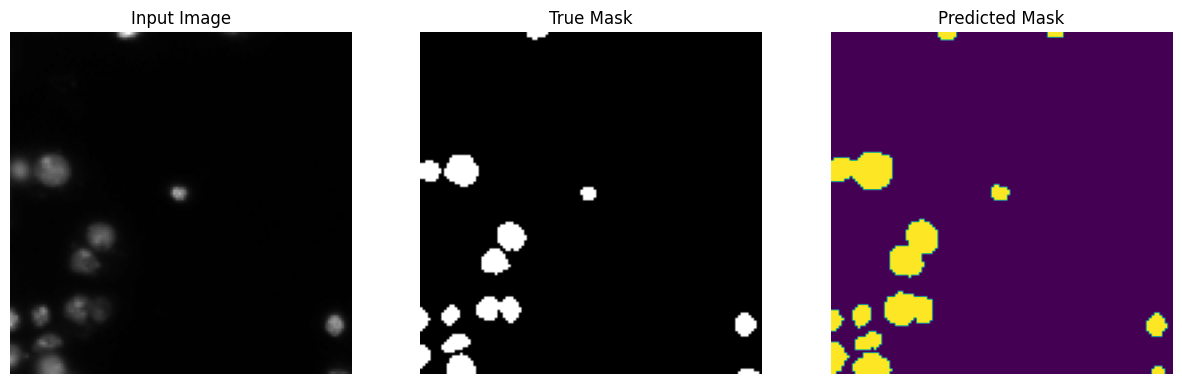

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


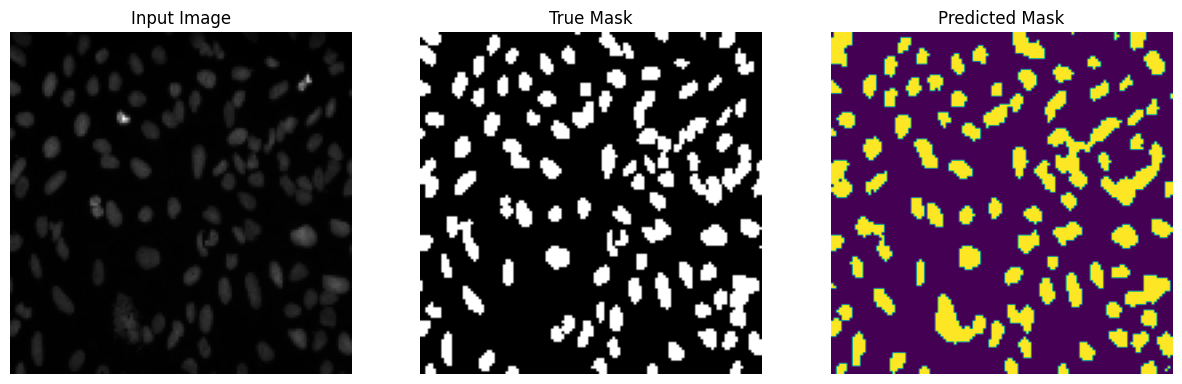

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


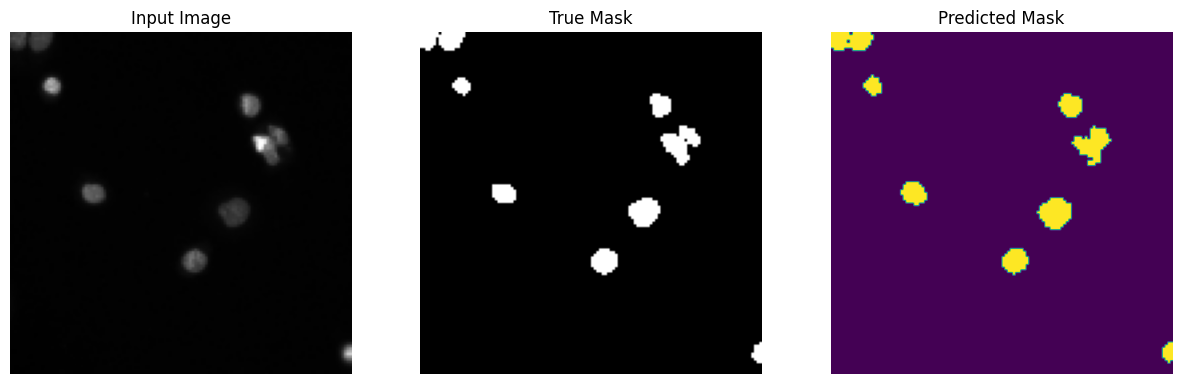

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


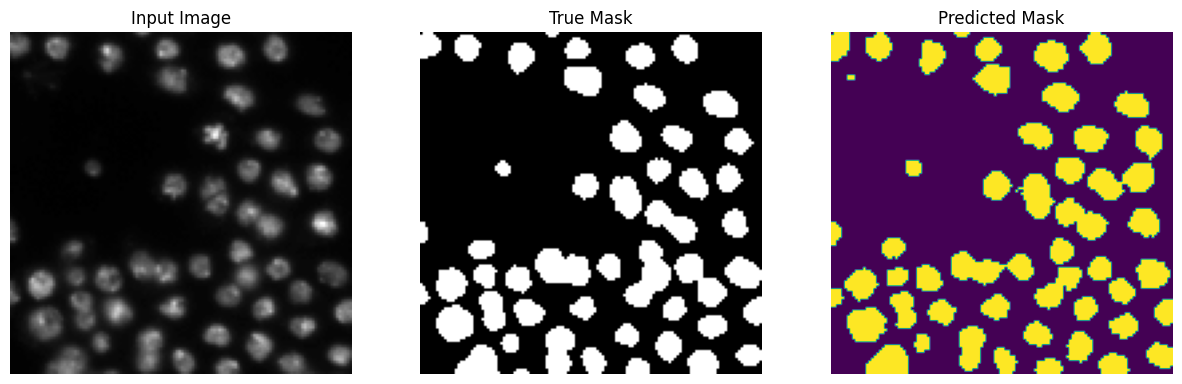

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


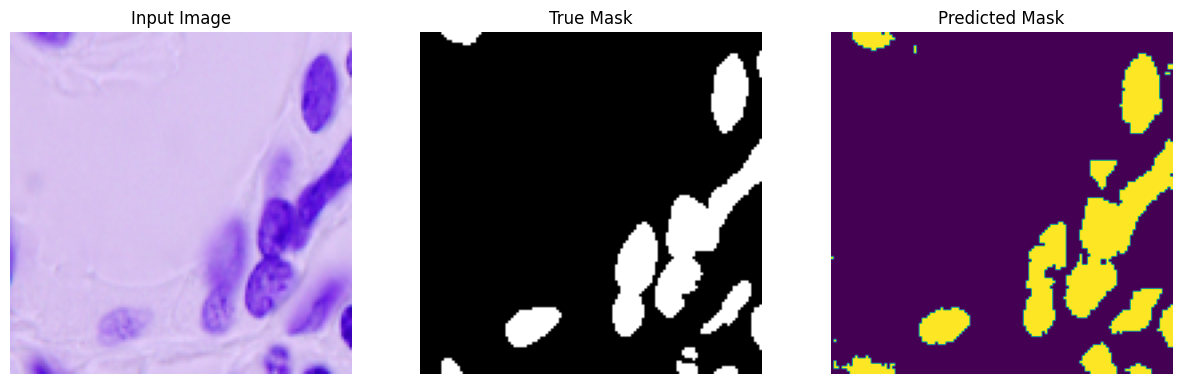

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


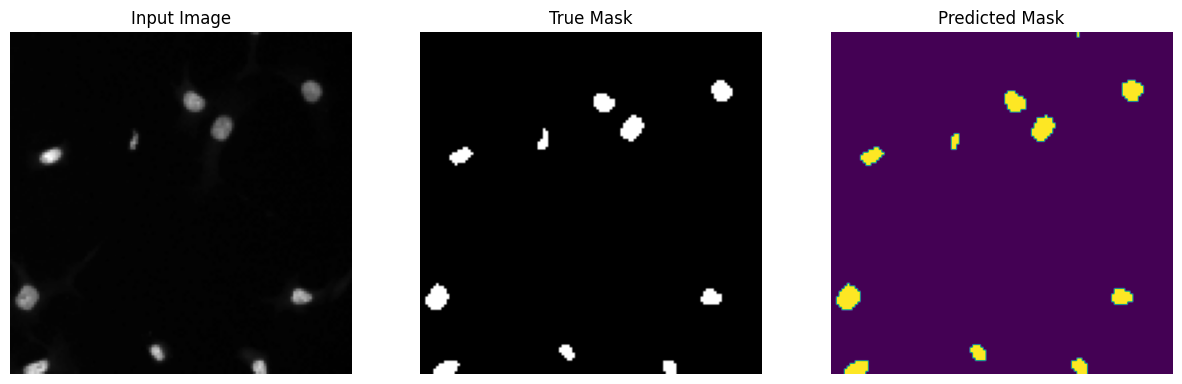

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


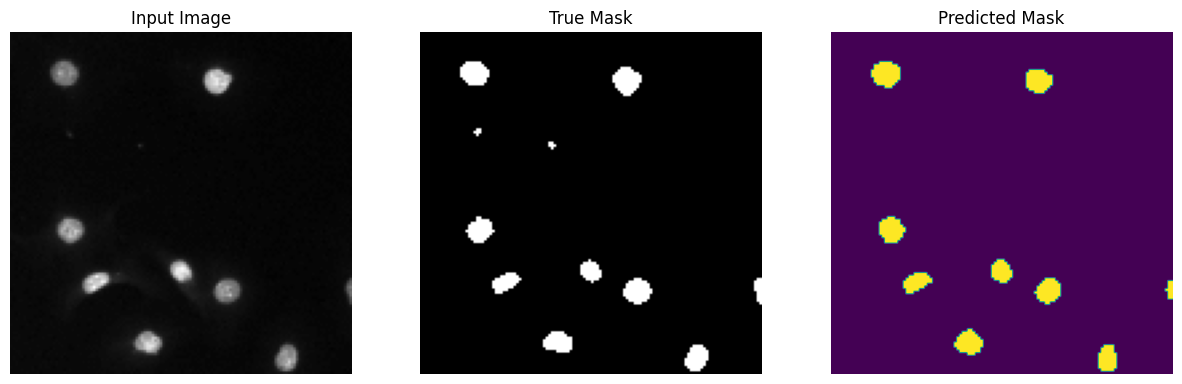

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


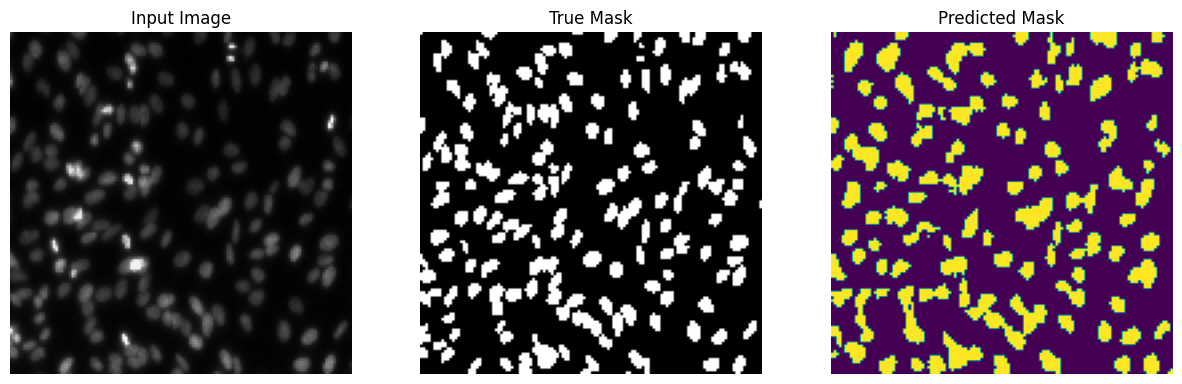

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


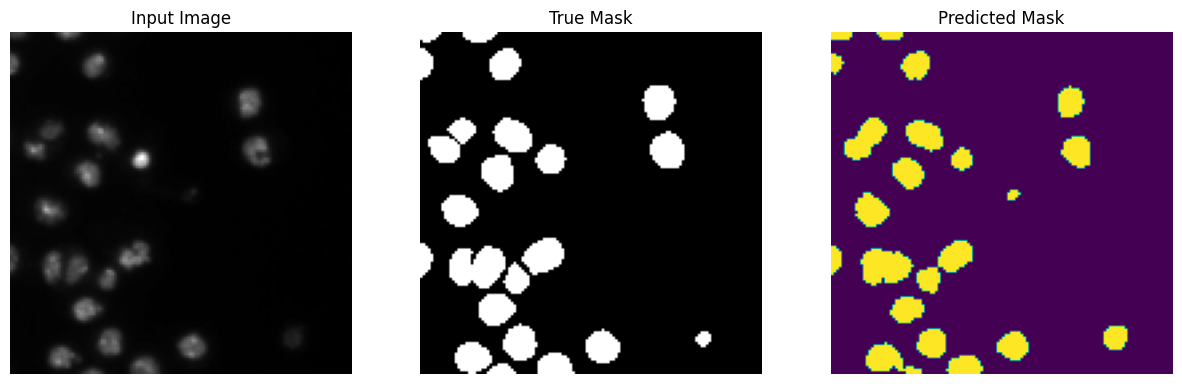

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


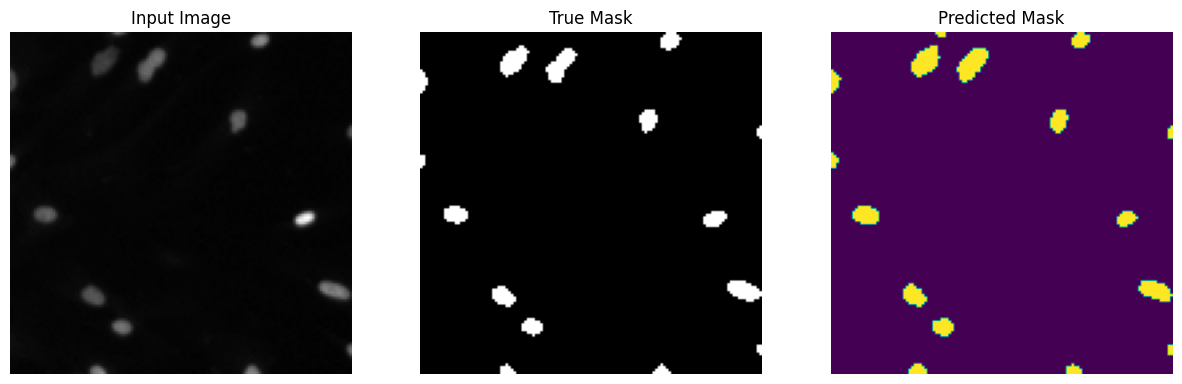

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


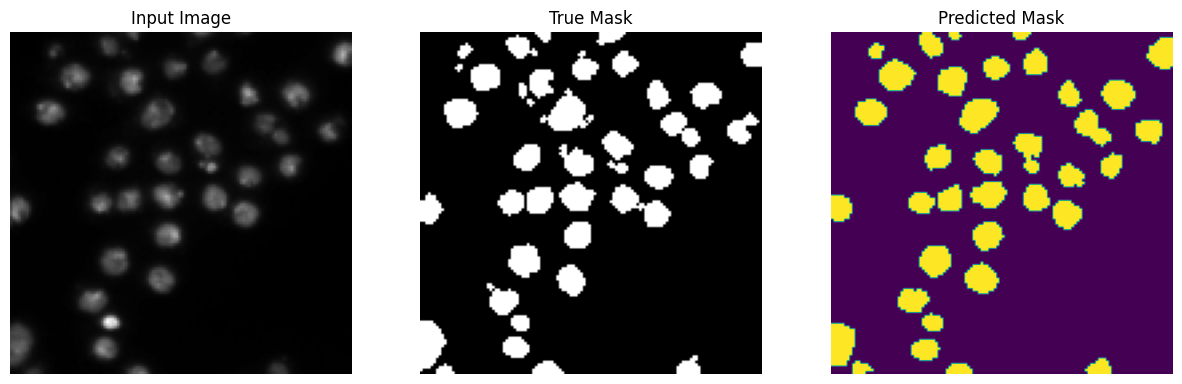

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


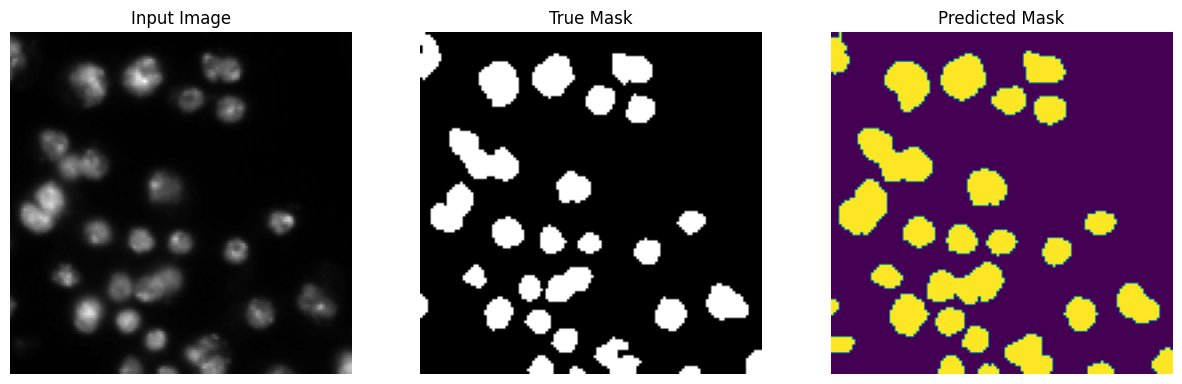

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


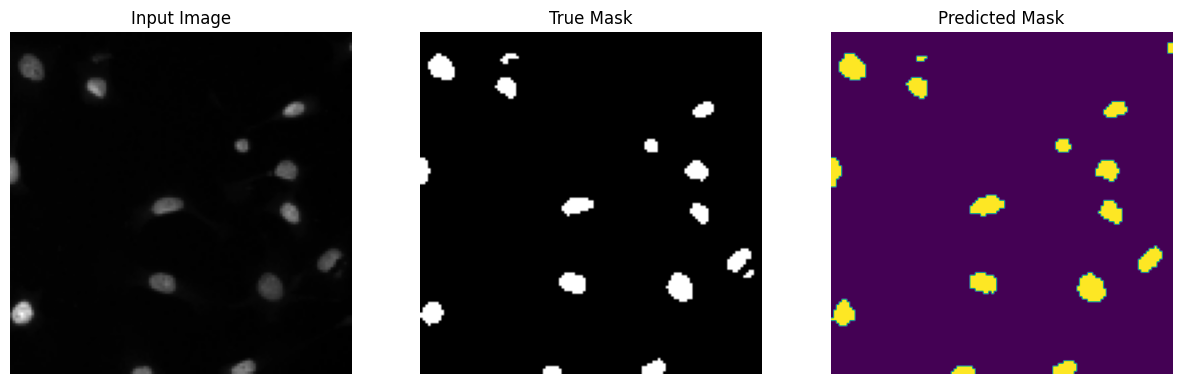

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


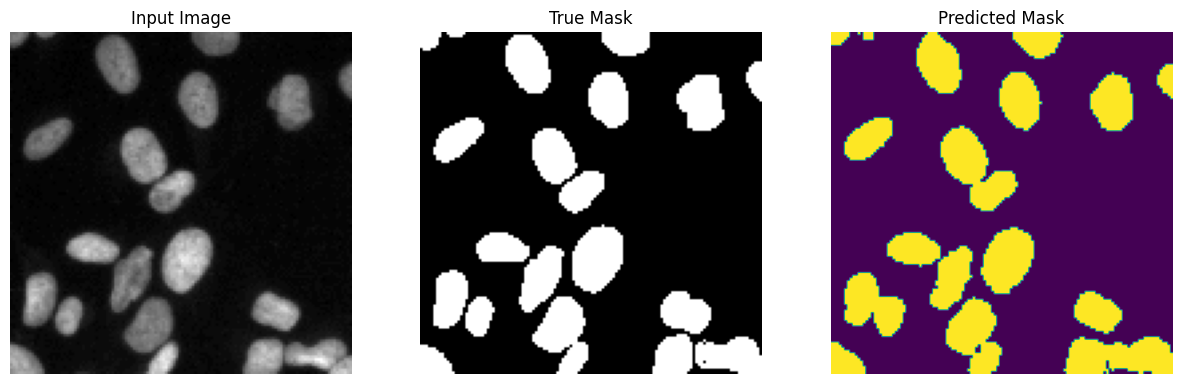

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


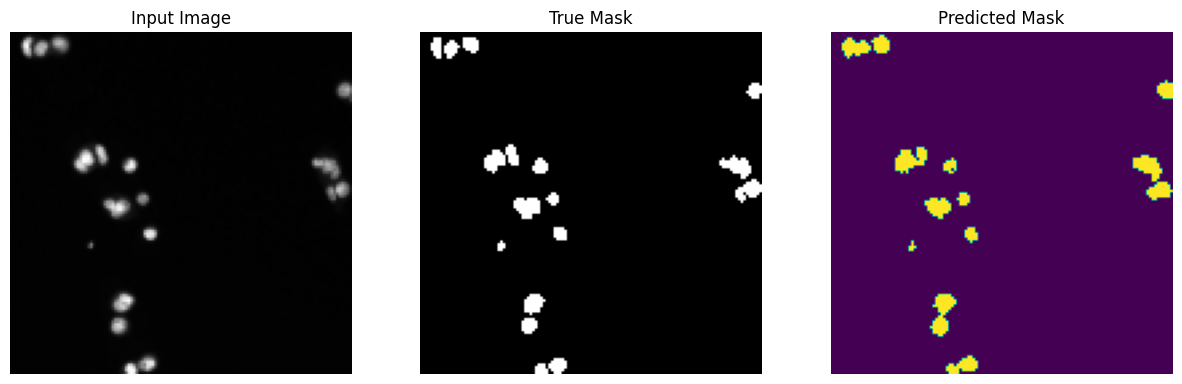

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


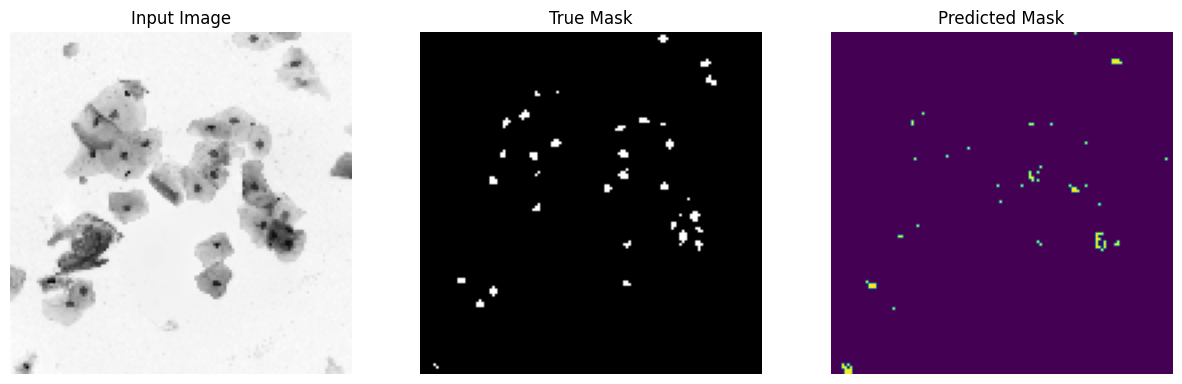

In [27]:
def display(display_list):
    """
    Helper function to display images, true masks (black and white), and predicted masks (colored with viridis).
    """
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        
        if i == 0:  # Input image (RGB)
            plt.imshow(keras.utils.array_to_img(display_list[i]))  # Show the input image
        elif i == 1:  # True mask (black and white)
            plt.imshow(tf.squeeze(display_list[i]), cmap='gray')  # Black-and-white colormap for true mask
        else:  # Predicted mask (colored with viridis)
            plt.imshow(tf.squeeze(display_list[i]), cmap='viridis')  # Colored colormap for predicted mask
            
        plt.axis('off')
    plt.show()


# Predict and visualize
for image, mask in test.take(33):
    # Ensure image has correct dimensions for prediction
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    pred_mask = loaded_model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)  # Convert probabilities to class indices
    pred_mask = pred_mask[0][..., tf.newaxis]  # Remove batch dimension

    # Call display with the input image, true mask, and predicted mask
    display([image[0], mask, pred_mask])